--- Model Performance ---
Model A | AUC: 0.7899 (Higher is better) | LogLoss: 0.5016 (Lower is better)
Model B | AUC: 0.6499 (Higher is better) | LogLoss: 0.6422 (Lower is better)


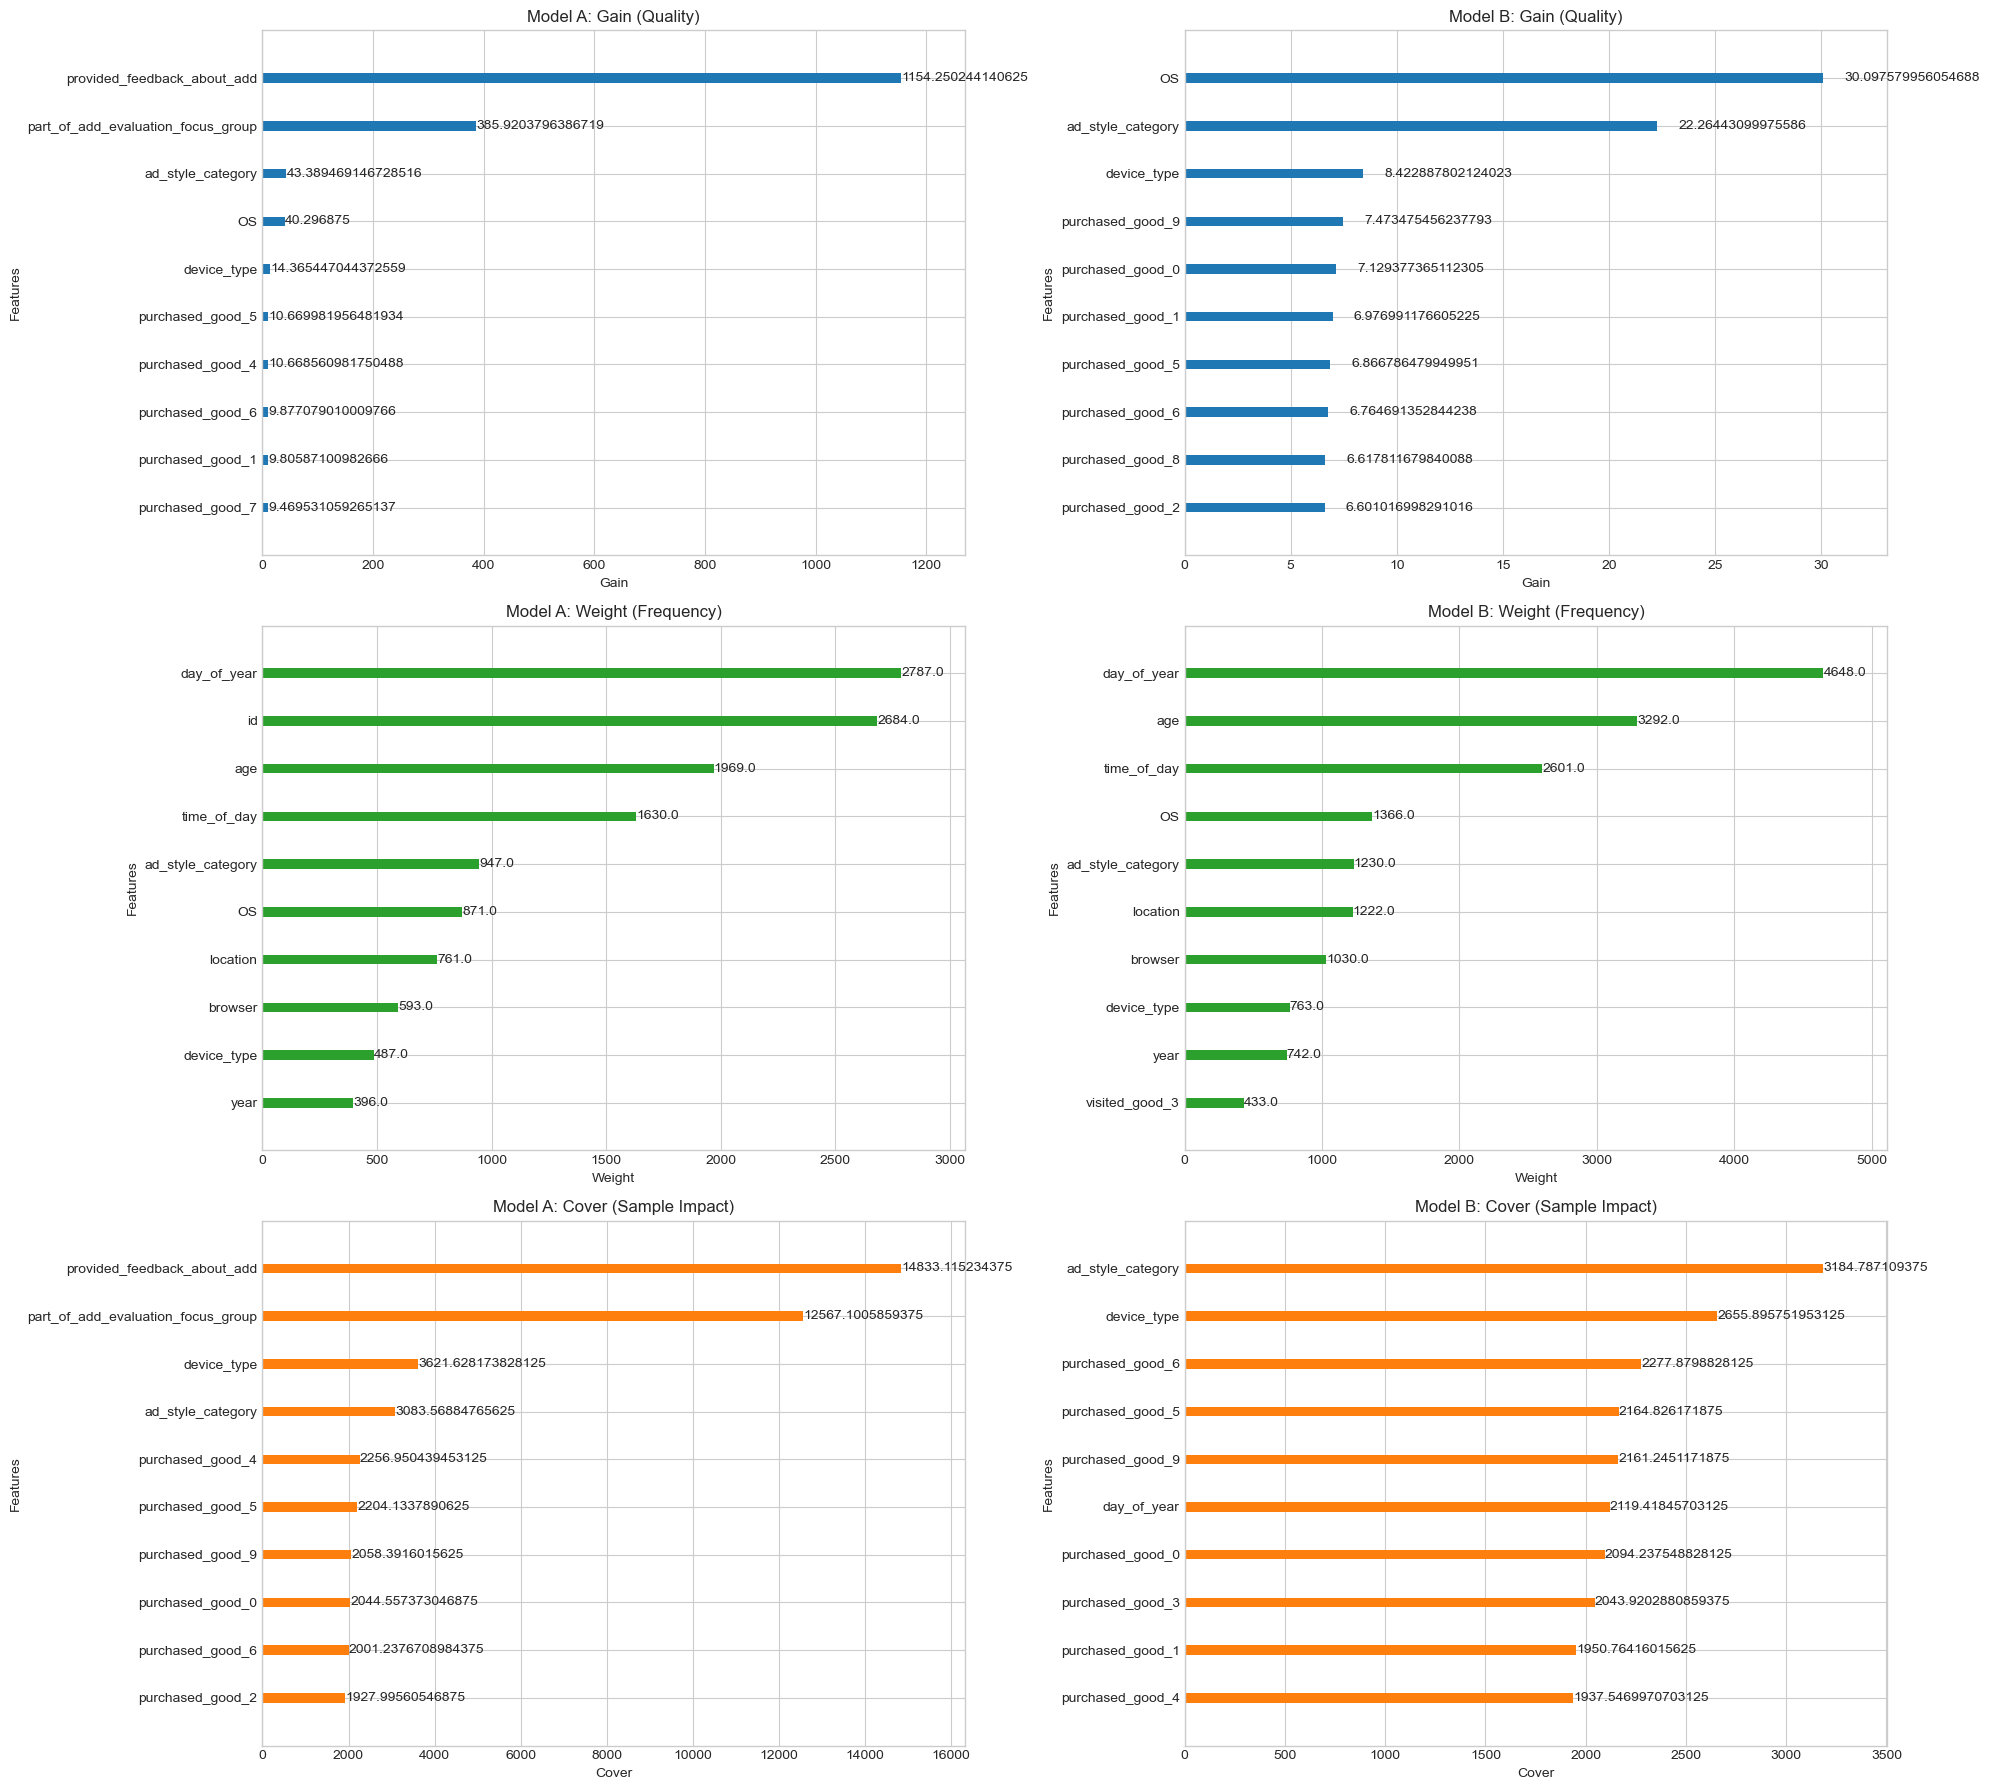

In [ ]:
# ==========================================
# CELL 1: Imports & Setup
# ==========================================
import pandas as pd
import xgboost as xgb
#import shap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.calibration import calibration_curve

# Use a clean plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# CELL 2: Data Loading & Preparation
# ==========================================
# 1. Load Data
df = pd.read_csv('click_prediction.csv')

# 2. Define Features (Strict Order from SbA_Upload.pdf Page 5)
feature_order = [
    'id', 'year', 'day_of_year', 'time_of_day', 'device_type', 
    'location', 'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add',
    'visited_good_0', 'visited_good_1', 'visited_good_2', 'visited_good_3', 
    'visited_good_4', 'visited_good_5', 'visited_good_6', 'visited_good_7', 
    'visited_good_8', 'visited_good_9',
    'purchased_good_0', 'purchased_good_1', 'purchased_good_2', 'purchased_good_3',
    'purchased_good_4', 'purchased_good_5', 'purchased_good_6', 'purchased_good_7',
    'purchased_good_8', 'purchased_good_9'
]

# 3. Create Feature Matrix X and Target y
# Fill NA with 0 as XGBoost handles sparse data, but explicit 0 helps consistency here
X = df[feature_order].fillna(0)
y = df['clicked_on_add']

# 4. Create DMatrix (Standard XGBoost input)
dtest = xgb.DMatrix(X, label=y, feature_names=feature_order)

# ==========================================
# CELL 3: Load Models
# ==========================================
model_a = xgb.Booster()
model_a.load_model('add_model_A.json')
model_a.feature_names = feature_order

model_b = xgb.Booster()
model_b.load_model('add_model_B.json')
model_b.feature_names = feature_order

# ==========================================
# CELL 4: Performance Metrics (How "Good"?)
# ==========================================
# Get predictions (probabilities)
preds_a = model_a.predict(dtest)
preds_b = model_b.predict(dtest)

# Calculate Scores
auc_a = roc_auc_score(y, preds_a)
loss_a = log_loss(y, preds_a)

auc_b = roc_auc_score(y, preds_b)
loss_b = log_loss(y, preds_b)

print("--- Model Performance ---")
print(f"Model A | AUC: {auc_a:.4f} (Higher is better) | LogLoss: {loss_a:.4f} (Lower is better)")
print(f"Model B | AUC: {auc_b:.4f} (Higher is better) | LogLoss: {loss_b:.4f} (Lower is better)")

# ==========================================
# CELL 5: Technique 1 - XGBoost Feature Importance (3x2 Grid)
# ==========================================
# Analyzes: Gain (Quality), Weight (Frequency), Cover (Impact Breadth)
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Row 1: Gain
xgb.plot_importance(model_a, importance_type='gain', max_num_features=10, 
                    title='Model A: Gain (Quality)', ax=axes[0, 0], color='tab:blue', xlabel='Gain')
xgb.plot_importance(model_b, importance_type='gain', max_num_features=10, 
                    title='Model B: Gain (Quality)', ax=axes[0, 1], color='tab:blue', xlabel='Gain')

# Row 2: Weight
xgb.plot_importance(model_a, importance_type='weight', max_num_features=10, 
                    title='Model A: Weight (Frequency)', ax=axes[1, 0], color='tab:green', xlabel='Weight')
xgb.plot_importance(model_b, importance_type='weight', max_num_features=10, 
                    title='Model B: Weight (Frequency)', ax=axes[1, 1], color='tab:green', xlabel='Weight')

# Row 3: Cover
xgb.plot_importance(model_a, importance_type='cover', max_num_features=10, 
                    title='Model A: Cover (Sample Impact)', ax=axes[2, 0], color='tab:orange', xlabel='Cover')
xgb.plot_importance(model_b, importance_type='cover', max_num_features=10, 
                    title='Model B: Cover (Sample Impact)', ax=axes[2, 1], color='tab:orange', xlabel='Cover')

plt.tight_layout()
plt.show()

